In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

pd.set_option('display.max_rows', None)

df = pd.read_json("./full_dataset/train.json", lines=True)

We will plot the data we're interested in from the whole dataset.

In [9]:
# Method to plot distributions using bar graph
def plot_bar(category, title, label):
    count = category.value_counts()
    print(count)

    count.plot(kind = 'bar')
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.show()

# Method to plot distributions using histogram
def plot_hist(category, title, label):
    count = category.value_counts().sort_index()
    print(count)

    count.plot(kind = 'bar')
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.show()

    plt.hist(category, bins=10)
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.show()

genre
electronic         67385
pop                53654
classical          26132
rock               11683
soundtrack          4285
jazz                2902
ambient              845
folk                 433
instrumentalpop      318
world                236
reggae               219
easylistening        146
latin                 77
country               43
experimental           9
alternative            6
popfolk                3
metal                  3
poprock                2
blues                  2
dance                  1
newage                 1
Name: count, dtype: int64


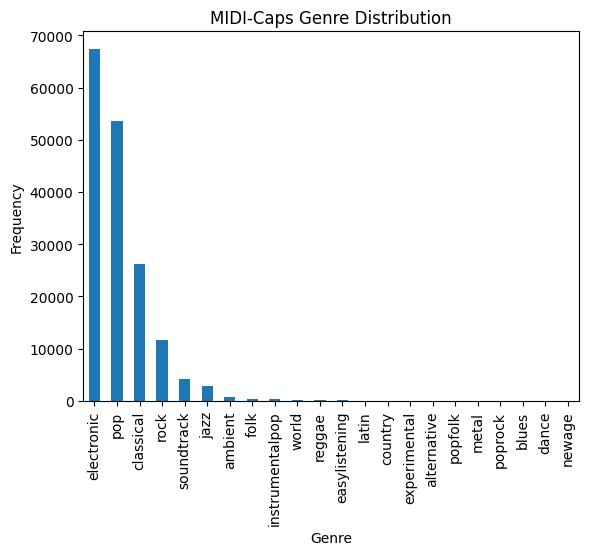

time_signature
4/4       140519
3/4         8589
2/4         6469
1/4         3028
6/8         2961
1/8         1041
3/8         1003
2/2          961
12/8         924
6/4          691
5/4          397
9/8          262
4/8          217
8/8          182
3/2          180
8/4          139
7/8          117
2/8           69
7/4           67
1/16          65
5/8           65
4/2           59
16/16         31
1/2           30
12/16         28
4/16          27
132/4         24
9/4           20
15/8          17
12/4          15
3/16          15
11/8          12
9/16          11
6/2           11
10/8          10
7/16           8
6/16           8
11/16          8
10/4           7
5/16           7
2/16           7
64/128         6
13/8           6
11/4           4
8/16           4
131/4          4
1/1            3
149/4          3
18/8           3
252/8          3
8/2            3
16/4           3
17/8           2
15/16          2
12/32          2
130/4          2
10/16          2
140/8          2

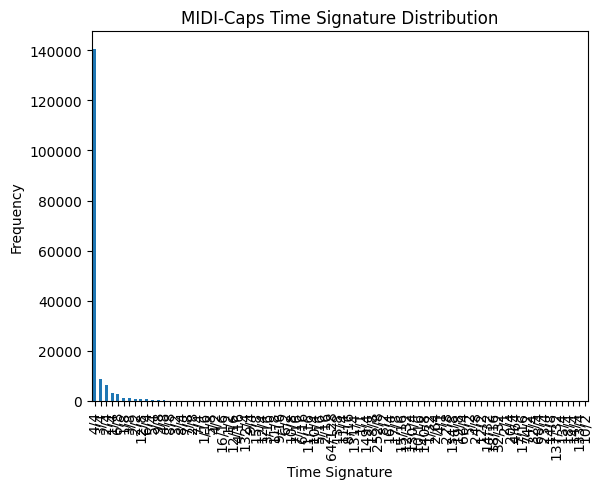

duration
3       103
4       347
5       334
6       404
7       715
8       573
9       218
10      254
11      304
12      211
13      837
14     1183
15      520
16      350
17      227
18      172
19      210
20      170
21      252
22      260
23      206
24      286
25      230
26      370
27      584
28      519
29      463
30      567
31      355
32      497
33      305
34      333
35      346
36      321
37      234
38      465
39      322
40      427
41      362
42      346
43      371
44      320
45      354
46      329
47      254
48      387
49      269
50      326
51      286
52      307
53      266
54      326
55      364
56      364
57      297
58      401
59      322
60      455
61      365
62      310
63      300
64      385
65      313
66      330
67      319
68      294
69      301
70      342
71      229
72      362
73      254
74      305
75      305
76      322
77      274
78      277
79      303
80      326
81      310
82      351
83      302
84      341
85     

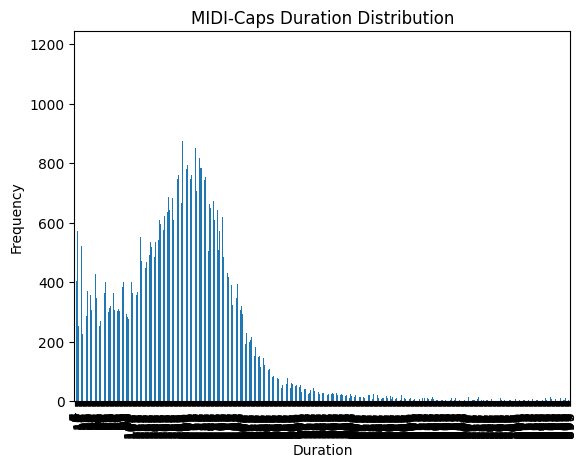

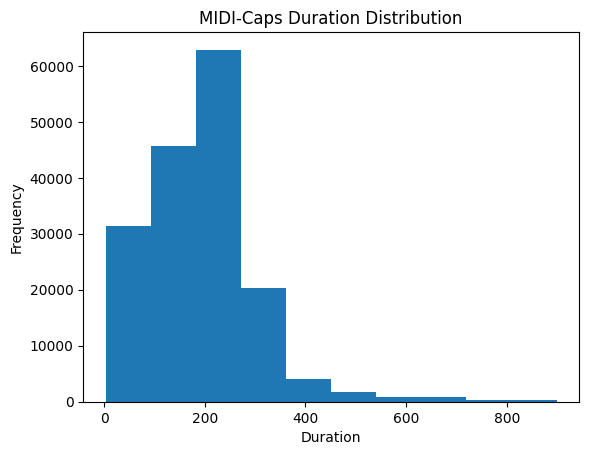

instrument_summary
Piano                    83048
Drums                    67636
String Ensemble          47142
Acoustic Guitar          45452
Electric Bass            33485
Acoustic Bass            19361
Electric Guitar          19044
Fretless Bass            17988
Clean Electric Guitar    16313
Synth Pad                14392
Distortion Guitar        14038
Overdriven Guitar        13951
Synth Strings            12515
Choir Aahs               11058
Flute                    10447
Brass Section            10380
Trumpet                   9863
Trombone                  7687
Alto Saxophone            7362
Synth Lead                7248
Rock Organ                7050
Clarinet                  7006
Synth Bass                6893
Synth Effects             6106
Violin                    5959
Vibraphone                5931
Synth Voice               5772
Synth Brass               5665
Tenor Saxophone           5454
Voice Oohs                5427
French Horn               5415
Electric Piano      

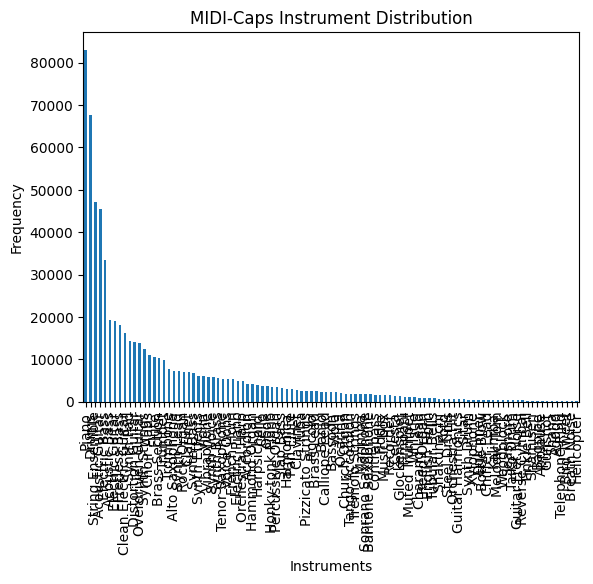

In [10]:
# Plot genre distribution
df['genre'] = df['genre'].str[0]
plot_bar(df['genre'], "MIDI-Caps Genre Distribution", "Genre")

# Plot time signature distribution
plot_bar(df['time_signature'],
    "MIDI-Caps Time Signature Distribution", "Time Signature")

# Plot duration distribution
plot_hist(df['duration'], "MIDI-Caps Duration Distribution", "Duration")

# Plot instrument distribution
df_instruments = df.explode('instrument_summary')
plot_bar(df_instruments['instrument_summary'],
    "MIDI-Caps Instrument Distribution", "Instruments")

We will remove unecessary data columns and drop missing values. To get a large enough sample size, we won't be using genres, time signatures, or instruments with under 10k entries. To remove outliers, we will remove songs under 10 seconds long.

In [11]:
# Remove unnecessary data columns
df = df.drop(['caption', 'genre_prob', 'mood', 'mood_prob', 'tempo_word',
    'duration_word', 'chord_summary_occurence', 'instrument_numbers_sorted',
    'all_chords', 'all_chords_timestamps', 'test_set'], axis = 1)

# Drop entries with empty or null values
df = df.dropna()
df = df[df['instrument_summary'].apply(lambda x: len(x) > 0)]
df = df[df['chord_summary'].apply(lambda x: len(x) > 0)]

# Drop genres under 10k
df = df[df['genre'].isin(['electronic', 'pop', 'classical', 'rock'])]

# Drop time signatures under 10k
df = df[df['time_signature'] == '4/4']

# Drop songs under 10 seconds
df = df[df['duration'] >= 10]

We will combine instruments into broader categories.

In [12]:
# Combine instruments into fewer categories
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Piano' if item in ['Electric Piano', 'Honky-tonk Piano', 'Harpsichord',
    'Clavinet', 'Celesta'] else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Drums' if item in ['Orchestra Hit', 'Synth Drum', 'Taiko Drum',
    'Reverse Cymbal', 'Melodic Tom', 'Timpani', 'Woodblock']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Strings' if item in ['String Ensemble', 'Synth Strings',
    'Tremolo Strings', 'Viola', 'Violin', 'Cello', 'Fiddle',
    'Orchestral Harp', 'Pizzicato Strings', 'Koto', 'Sitar', 'Shamisen']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Acoustic Guitar' if item in ['Banjo', 'Dulcimer']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Bass' if item in ['Electric Bass', 'Acoustic Bass', 'Fretless Bass',
    'Synth Bass', 'Slap Bass', 'Contrabass']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Electric Guitar' if item in ['Guitar Harmonics', 'Guitar Fret Noise',
    'Distortion Guitar', 'Overdriven Guitar', 'Clean Electric Guitar']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Choir' if item in ['Choir Aahs', 'Synth Voice', 'Voice Oohs']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Woodwinds' if item in ['Flute', 'Pan Flute', 'Shakuhachi', 'Ocarina',
    'Recorder', 'Piccolo', 'Whistle', 'Clarinet', 'Bassoon', 'Oboe',
    'Bagpipe'] else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Brass' if item in ['Brass Section', 'Synth Brass', 'Brass Lead',
    'Trumpet', 'Muted Trumpet', 'Trombone', 'Alto Saxophone',
    'Tenor Saxophone', 'Soprano Saxophone', 'Baritone Saxophone',
    'French Horn', 'Tuba', 'English Horn']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Synths' if item in ['Synth Pad', 'Synth Effects', 'Charang Lead',
    'Chiffer Lead', 'Synth Lead']
    else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Organ' if item in ['Rock Organ', 'Hammond Organ', 'Percussive Organ',
    'Church Organ', 'Reed Organ', 'Accordion', 'Tango Accordion', 'Harmonica',
    'Calliope Lead'] else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Xylophone' if item in ['Glockenspiel', 'Vibraphone', 'Marimba',
    'Steel Drums', 'Tubular Bells', 'Tinkle Bell', 'Agogo', 'Music box',
    'Kalimba'] else item for item in x])
df['instrument_summary'] = df['instrument_summary'].apply(lambda x:
    ['Other' if item in ['Seashore', 'Applause', 'Gunshot', 'Telephone Ring',
    'Bird Tweet', 'Breath Noise', 'Helicopter', 'Bottle Blow', 'Shana']
    else item for item in x])

# Drop instruments under 10k
df = df[df['instrument_summary'].apply(lambda x: 'Other' not in x)]

We will plot the genre, time signature, duration, and instrument distribution of the dataset after cleaning the data.

genre
electronic    52470
pop           41423
classical     15851
rock          10292
Name: count, dtype: int64


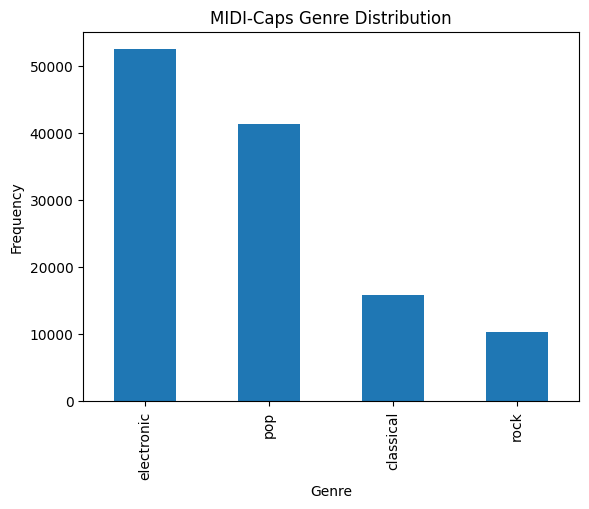

time_signature
4/4    120036
Name: count, dtype: int64


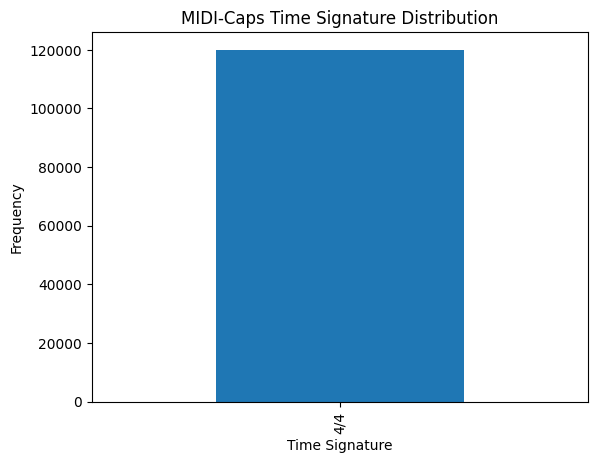

duration
10     168
11     138
12     109
13     366
14     653
15     269
16     122
17     132
18      99
19     122
20      96
21     161
22     150
23     109
24     145
25     120
26     183
27     300
28     297
29     273
30     328
31     182
32     210
33     186
34     196
35     204
36     190
37     131
38     291
39     178
40     278
41     223
42     219
43     206
44     181
45     212
46     216
47     150
48     197
49     158
50     192
51     176
52     172
53     171
54     183
55     216
56     235
57     170
58     243
59     209
60     292
61     206
62     183
63     166
64     245
65     189
66     210
67     187
68     175
69     187
70     219
71     133
72     210
73     158
74     192
75     186
76     194
77     178
78     167
79     185
80     187
81     179
82     219
83     195
84     207
85     176
86     191
87     196
88     233
89     214
90     256
91     177
92     223
93     196
94     209
95     165
96     356
97     172
98     240
99     168
1

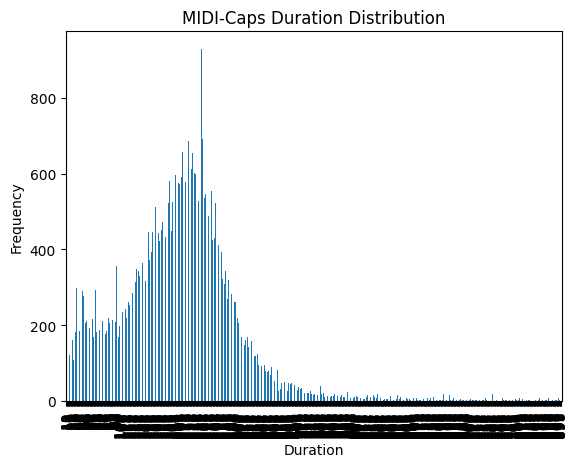

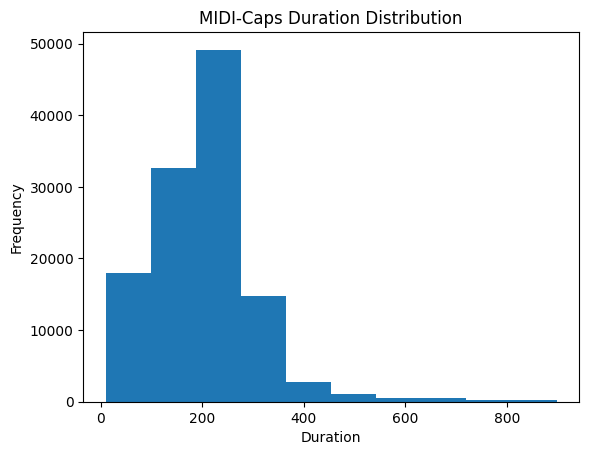

instrument_summary
Piano              76068
Bass               67624
Strings            64886
Drums              59356
Electric Guitar    56537
Brass              47214
Acoustic Guitar    36967
Synths             24494
Woodwinds          23484
Organ              22911
Choir              17860
Xylophone          10383
Name: count, dtype: int64


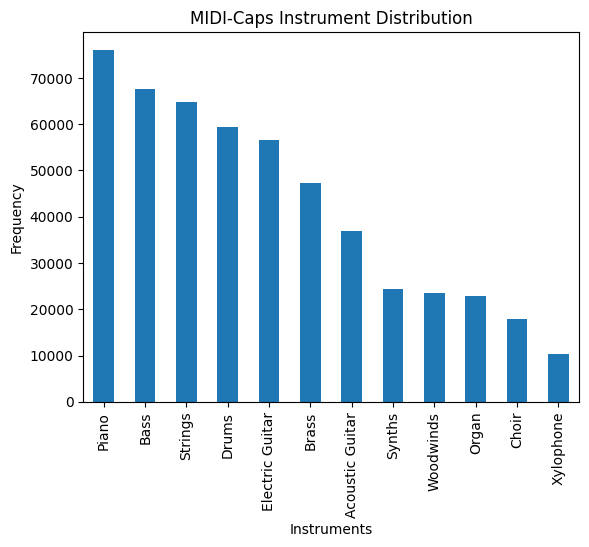

In [13]:
# Plot genre distribution
plot_bar(df['genre'], "MIDI-Caps Genre Distribution", "Genre")

# Plot time signature distribution
plot_bar(df['time_signature'],
    "MIDI-Caps Time Signature Distribution", "Time Signature")

# Plot duration distribution
plot_hist(df['duration'], "MIDI-Caps Duration Distribution", "Duration")

# Plot instrument distribution
df_instruments = df.explode('instrument_summary')
plot_bar(df_instruments['instrument_summary'],
    "MIDI-Caps Instrument Distribution", "Instruments")

We will save the new information into a new json file and keep the MIDI files we want in a new folder.

In [ ]:
# Create new json file based on cleaned dataframe
df.to_json('dataset.json', orient='records', lines=True)

# Create new dataset based on remaining filepaths
full_datasets_dir = 'full_datasets'
dataset_dir = 'dataset'
for index, row in df.iterrows():
    file_path = os.path.join(full_datasets_dir, row['location'])
    if os.path.isfile(file_path):
        file_name = os.path.basename(file_path)
        destination_path = os.path.join(dataset_dir, file_name)
        shutil.copy(file_path, destination_path)